# [LEGALST-123] Lab 06: Regression and Causal Inference 

This lab will review Ordinary Least Squares regression, the use of regression for causal inference, and interpreting regression models (including the idea of hypothesis testing). The idea here is to review how causal inference models are used in the social sciences (here, with the ANES data) and how to interpret those models.

In [1]:
# dependencies
from collections import Counter
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
%matplotlib inline
import matplotlib.pyplot as plot
plot.style.use('fivethirtyeight')

## Data

We'll continue using the ANES data for this lab!

In [2]:
anes = pd.read_csv('../data/anes/ANES_legalst123_cleaned.csv')
anes.head()

,Unnamed: 0,pre_election_weight_ftf,post_election_weight_ftf,pre_voting_status,pre_economy_last_year,pre_party_id,pre_gun_access_importance,pre_unauthorized_immigrants,pre_birthright_citizenship,pre_govt_assist_to_blacks,...,post_discrim_christian,post_discrim_transgender,post_discrim_personal,post_skintone,post_discrim_skintone,post_support_trump,post_gender,post_age_est,post_inform_level,post_intelligence
0,0,0.887,0.927,3,5.0,7.0,2.0,3.0,4.0,7.0,...,4.0,4.0,NaN,3.0,4.0,NaN,NaN,NaN,4.0,4.0
1,1,1.160,1.084,3,3.0,6.0,1.0,1.0,1.0,7.0,...,4.0,1.0,NaN,3.0,4.0,NaN,NaN,NaN,1.0,2.0
2,2,0.416,0.398,1,3.0,3.0,2.0,1.0,7.0,7.0,...,2.0,1.0,NaN,2.0,4.0,NaN,NaN,NaN,4.0,3.0
3,3,0.385,0.418,4,3.0,5.0,1.0,3.0,4.0,5.0,...,3.0,2.0,NaN,4.0,4.0,NaN,NaN,NaN,2.0,2.0
4,4,0.693,0.726,3,3.0,3.0,1.0,3.0,6.0,7.0,...,2.0,3.0,NaN,2.0,5.0,NaN,NaN,NaN,4.0,3.0


In [3]:
# see those variable names from the csv file again; you may need to go back to the dataframes lab
# to see what the variable number is in order to look that variable up in the codebook

# anes.columns.values

## Ordinary Least Squares (OLS) regression models

In the social sciences, regression is often used to support a causal argument based in some kind of theory of human action. In effect, what it represents mathematically is "what is the effect of a unit change in $x$ (the cause of interest) on $y$ (the outcome of interest), holding everything else equal." Another way of thinking about it is as the partial correlation between a single variable $x$ and an outcome $y$. Correlation and regression are introduced quite well in the Adhikari and DeNero text, so here we are trying to show how social scientists use regression to make causal arguments. We are going to use some simple examples with the ANES data we have already used.

### A really simple model
So let's try a simple model that tries to understand people's receptiveness to scientific information as an outcome of individual-level attributes. Some of these attributes are categorical and some are on scales. For this exercise those individual attributes will be (and go ahead and look at the details in the [ANES 2016 Codebook](https://electionstudies.org/wp-content/uploads/2018/12/anes_timeseries_2016_userguidecodebook.pdf))

party ID: **pre_party_id** (V161158x in the ANES 2016 Codebook)<br>
level of education: **pre_education_level** (V161270)<br>
gender self-ID: **pre_gender** (V161342)<br>
age level: **pre_age_group** (V161267x)<br>
race: **pre_race**(V161310x) and <br>
income: **pre_income** (V161361x) 

Since we don't have an item in the survey that directly measures receptiveness to information, we will use the item on favoring or opposing vaccination as a proxy for how receptive someone is to scientific information because of the debunked link between vaccinations and autism and the ongoing campaign of the antivaxxers.

**post_vaccines** (V162147x)

The theory linking these individual-level variables comes from the voting behavior literature, which leads us to think that people will form attitudes toward scientific knowledge based on partisan cues and education, but we also know that race is an important political cleavage and that age can be a substitute for some kinds of formal education. Income may or may improve access to high quality information but it is usually important in conditioning a person's knowledge about the world, so we will include it, and we will include gender since it is also an important facet of identity that can affect views toward the political world.

### OLS regression: assumptions about data

There are a number of assumptions that regression techniques require that we will keep returning to in class. Here's a little list.

1. independent variables are quantitative or dichotomous; dependent variable is quantitative, continuous, and unbounded
2. IVs have variance not equal to 0 (ie. there is some variation in their value) (duh, otherwise they’d be constants)<br>
3. no independent variable can be precisely linearly predicted from all the others (e.g., if one variable is always approximately the sum of two others, the regression will get confused, because then there are many sets of coefficients which are equivalent)<br>
4. for each set of values for the independent variables, the mean value of the error term is zero (i.e. there is no "bias" in the error: it is just as likely that the measurement is off in the positive direction as in the negative direction)<br>
5. each IV is uncorrelated with the error term<br>
6. the variance of the error term for each set of values for the IVs is constant (homoskedasticity assumption)<br>
7. error terms for any two observations of the values of IVs are uncorrelated<br>
8. error terms for each set of values for the IVs are normally distributed<br>

This means we have some work to do first with the variables in our model.

#### Cleaning and preparing the data 

There are several things we need to in order to end up with an interpretable model (and there are other things that we can do but won't, like rescale all the independent variables on a 0 to 1 scale, which again is for interpretability).
1. deal with missing data to exclude those cases from our analysis
2. recode variables that are categorical into new variables that are dichotomous (i.e., that take value either 0 or 1)
3. recode scales in a consistent direction for interpretability

We will also be making the "interval assumption" with the dependent variable **post_vaccines** which is a constructed scale with 7 response categories. You may want to include a markdown cell that says all of this (and why the interval assumption is or isn't OK).

In [4]:
# replace missing data with NaN (we are not losing it since we are not overwriting the data file)
#   to do this without losing unnecessary cases (since we will drop cases with NaN values)
#   we should first make a new dataframe

regression_df = anes[['pre_party_id', 'pre_education_level', 'pre_gender', 'pre_age_group',\
                         'pre_race', 'pre_income', 'post_vaccines']].copy()
print('shape of new df ', regression_df.shape)
regression_df.where(regression_df>0, inplace=True) # because negative integers were used for missing data

shape of new df  (4271, 7)


shape of new df after dropping rows with missing values  (3408, 7)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1110d00b8>,
      dtype=object)

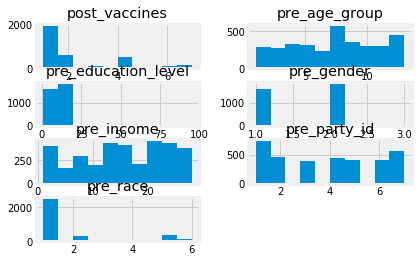

In [5]:
# drop the cases with missing data
regression_df.dropna(axis=0, inplace=True)
print('shape of new df after dropping rows with missing values ', regression_df.shape)
regression_df.hist(layout=(4,2)) # to see that the data all check out

#### Recoding all of those variables to fit regression assumptions

In [6]:
"""
you will need to refer to the codebook here
recode categorical variables into dichotomous variables
    the usual practice for dichotomous (or "dummy") variables is to code the category you are interested in
    as 1 and all the other categories as 0; you can also recode categorical variables into a bunch of different
    dummy variables as long as you exclude one category (otherwise you would have a perfect collinearity problem)
    the excluded category then becomes your baseline
this is also the place to recode scales into an order consistent with your question (e.g., if you think that people 
who score high on a causal variable should also score high on the outcome variable, you should make sure they are 
bothcoded in the same direction)
"""
regression_df['post_vaccines'].replace(to_replace=[1,2,3,4,5,6,7], value=[7,6,5,4,3,2,1], inplace=True)
regression_df['pre_party_id'].replace(to_replace=[1,2,3,4,5,6,7], value=[0,0,0,0,1,1,1], inplace=True)
# just made party ID into either Republican (1) or not Republican (0)
regression_df['pre_education_level'].replace(to_replace=[90,95], value=[9,9], inplace=True)
# note that pre_education_level is really ordinal, and we are just setting the value for the two residual
# 'other' categories to the median (HS finisher) while also making the implicit assumption 
# that it is an interval measure that ranges 1:16
regression_df['pre_gender'].replace(to_replace=[1,2,3], value=[1,0,0], inplace=True)
# making gender dichotomous and assuming that male gender will be different
# while 'pre_age_group' is ordered it is not exactly an interval measure but we can say it is sort of close
regression_df['pre_race'].replace(to_replace=[1,2,3,4,5,6], value=[1,0,0,0,0,0], inplace=True)
# made race of respondent into a dichotomous variable where "white" is 1, since that political identity
#    has historically been salient across many dimensions
# pre_income is again really and ordered list of income responses but we will treat it like it is an interval measure

AxesSubplot(0.08,0.125;0.87x0.755)


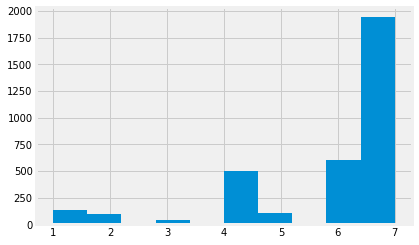

In [7]:
print(regression_df['post_vaccines'].hist())

AxesSubplot(0.08,0.125;0.87x0.755)


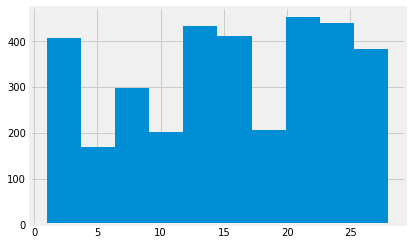

In [8]:
print(regression_df['pre_income'].hist())

### OLS regression: making an inference from data

#### Making an OLS model
Now that the data are in a form that we can use, implement the regression model below. [Here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score) is documentation for linear regression in SciKit Learn. Later in the course, when we talk about prediction, we will talk about training linear models on a set of training data and testing them on data reserved for that purpose. Right now we are interested in fitting the model and seeing if our hypothesized relationships hold up.

In [9]:
# first we need to specify the causal variables 
X = regression_df.drop(['post_vaccines'], axis=1)

# and the outcome variable
y = regression_df['post_vaccines']

In [10]:
# OLS regression model
#    because Scikit-learn does not give confidence intervals for the regression coefficients
#    we need to use Statsmodels.org package 
#    https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html
# disclaimer: Prof. Marshall learned about this on Stackexchange

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())



                            OLS Regression Results                            
Dep. Variable:          post_vaccines   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     25.38
Date:                Mon, 11 Feb 2019   Prob (F-statistic):           1.23e-29
Time:                        12:27:12   Log-Likelihood:                -6459.2
No. Observations:                3408   AIC:                         1.293e+04
Df Residuals:                    3401   BIC:                         1.298e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   4.7716    

### Interpreting OLS models: coefficients and understanding them

#### Hypothesis Testing

Here's a little review of what we already talked about, applied to the interpretation of regression models.

The goal in conducting a hypothesis test is to answer the question, "Was it likely to observe my test statistic due to chance?" We say something is statistically significant if it is sufficiently far enough away from the center of an empirical distribution, and therefore unlikely to have occurred just by chance.

The basic way to frame a hypothesis test is as follows:

1. Define a null $(H_O)$ and alternative $(H_A)$ hypothesis. The null hypothesis is usually framed as "no statistical relationship between the observed data and the background distribution" and the alternative hypothesis is the opposite. More concretely, the null is our default position, and assumes that the observed statistic likely came from the background distribution.

2. Calculate a test statistic (for example, t-test, $\chi^2$, etc.)

3. Check if the test statistic is far enough away from the center of the distribution. Traditionally, this was done by checking against a reference table, but in Python, we'll use p-values. Typically, a p value of less than .05 (meaning that only 5% of observations should fall where the test statistic does) is used as the threshold for statistical significance in the social sciences.

4. Either reject or fail to reject the null hypothesis.

When we are talking about interpreting regression models, we are mainly interested in the coefficients for each of the important causal variables we have identified (using induction or perhaps theory as it has developed in the social sciences) and whether or not we can reject the null hypothesis that the coefficient is zero at some confidence level. Usually the social sciences settles on the 95% confidence interval; in other words, assuming that our estimate is correct, in repeated sampling from the underlying population we would get an estimate within the confidence interval 95 times out of 100. If zero is not in the interval, then we can say we have found an effect. Sort of arbitrary but at least it provides a standard of confidence.

_explain what the model shows here_<br>
**The model, first of all, does not account for much of variance in the dependent variable 'post_vaccine'--the measure of fit (R-squared or coefficient of determination) is not very good even by political science standards. But some of our causal measures have an effect: being a Republican tends to reduce how much voters support vaccination in schools by 0.2 points on the seven-point scale; being male also reduces support but by half that amount. Education has the expected effect of more information generating more support for vaccination, despite the antivaxxers. Being white (perhaps because of the inequality of medical care in the US), being older, and earning more all seem to be positively associated with supporting vaccination. **

## Try Your Own Model on Voters!

Now that we've run through a causal model that aims at explanation of receptiveness to scientific information, try one of your own. Since we all know something about U.S. politics, come up with a explanatory model for a political orientation as measured by the variables in the piece of the ANES dataset we have been using. In a markdown cell, outline the model, and in another markdown cell, describe what you have found.

_your model in words_<br>

In [11]:
# implement your model here, commenting on the steps you take to clean the data and make the variables
# ready for use in an OLS regression model

_description of what you found (and a negative finding is still a finding)_<br>